# Global mean Sea Surface Temperatures

## Libraries

### Hay alguna librería a mayores para lo del polígono

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
from matplotlib.dates import DateFormatter
import platform
import os

from dask.distributed import Client
from dask import delayed
import dask

import cartopy.crs as ccrs
import cartopy
import cartopy.feature as cfeature

import pyproj
from shapely.geometry import Polygon, Point
from shapely.ops import transform

plt.rcParams['figure.figsize'] = (10, 4)

## Functions

In [21]:
def point_in_polygon(lon, lat, polygon):
    point = Point(lon, lat)
    return polygon.contains(point)

In [22]:
# Define a transformation to ensure the polygon's CRS matches
def transform_polygon(polygon, src_crs='epsg:4326', tgt_crs='epsg:4326'):
    # Transform the polygon to match the DataArray CRS if needed
    proj = pyproj.Transformer.from_proj(pyproj.Proj(src_crs), pyproj.Proj(tgt_crs), always_xy=True)
    return transform(lambda x, y: proj.transform(x, y), polygon)

## Settings

In [23]:
year1= 1982
year2= 2025

In [24]:
# Settings compute de climatoloy
yearC1='1982'
yearC2='1992'

## Directories

In [25]:
HOME=os.environ['HOME']   
f = open(HOME+'/.env', 'r')
for line in f.readlines():
    Name=line.strip().split('=')[0]
    Content=line.strip().split('=')[-1]
    if Name=='dirData' or Name=='dirAnalisis':
        exec(Name + "=" + "'" + Content + "'")
f.close()

In [26]:
if os.uname().nodename.lower().find('eemmmbp') != -1:
    base_file = dirData + '/Satelite/noaa.oisst.v2.highres/NC/sst.day.mean'
    dataDir   = dirAnalisis + '/SSTGlobalAnalysis/data'
elif os.uname().nodename.lower().find('sagams') != -1:
    base_file = dirData + '/Satelite/noaa.oisst.v2.highres/NC/sst.day.mean'
    dataDir   = dirAnalisis + '/SSTGlobalAnalysis/data'
elif os.uname().nodename.lower().find('rossby') != -1:
    base_file = dirData + '/Satelite/noaa.oisst.v2.highres/NC/sst.day.mean'
    dataDir   = dirAnalisis + '/SSTGlobalAnalysis/data'

In [27]:
Titulos = ['Oceano Global','Hemisferio norte','Hemisferio sur',
           'Atlántico Norte','Iberian Canary Basin',
           'Demarcación marina levantino-balear', 'Demarcación marina noratlántica','Demarcación marina canaria','Demarcación sudatlántica','Demarcación Estrecho y Alborán']
Titulos_short = ['GO','NH','SH',
                 'NAtl','IBICan',
                 'LEB', 'NOR','CAN','SUD','ESA']

## Load data

In [28]:
it=4

In [29]:
titulo = Titulos[it]
titulo_short = Titulos_short[it]

In [30]:
files = [f'{base_file}.{year}.nc' for year in range(year1, year2+1)]

In [31]:
DS = xr.open_mfdataset(files)

### Aquí empiezan las variaciones del script original

In [32]:
lat_point_list = [40, 40, 30, 30, 40]
lon_point_list = [354.5, 360, 360, 354.5, 354.5]

polygon_geom = Polygon(zip(lon_point_list, lat_point_list))
polygon = transform_polygon(polygon_geom)

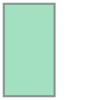

In [33]:
polygon

In [ ]:
sst = DS.sst.sel(lat=slice(20, 47),lon=slice(325,360)) 
# Se ha cambiado la latitud máxima para adaptarla al área que se decició en la reunión de la figura de SST

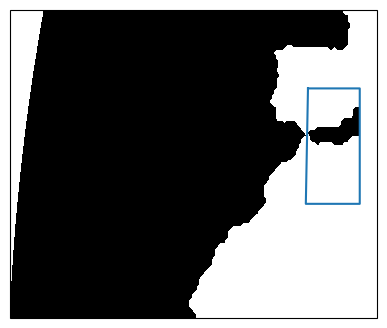

In [35]:
ax = plt.axes(projection=ccrs.Robinson())
ax.contourf(sst.lon,sst.lat,sst[-1,:,:],10,colors='k',
           transform=ccrs.PlateCarree())
ax.plot(lon_point_list, lat_point_list, transform=ccrs.PlateCarree())

In [40]:
mask = np.array([[point_in_polygon(lon,lat,polygon) 
                  for lon in sst.lon.values] 
                  for lat in sst.lat.values])
        
sst = sst.where(~mask)

### Y a partir de aquí, se continúa con el script original

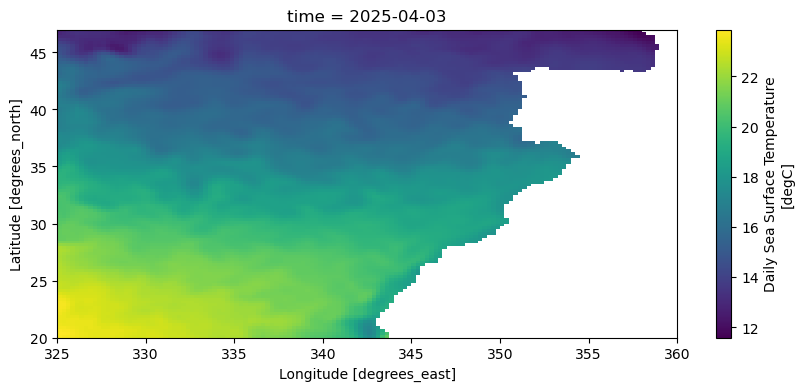

In [37]:
sst[-1,:,:].plot()

In [55]:
print('>>>>> '+titulo)

>>>>> Iberian Canary Basin


## Daily analysis

In [56]:
print('>>>>> Daily'+titulo+titulo_short)

>>>>> DailyIberian Canary BasinIBICan


In [57]:
## Calculate mean weigthtened
weights = np.cos(np.deg2rad(sst.lat))
weights = weights/weights.max()
weights.name = "weights"
sst_weighted = sst.weighted(weights)
sst_wmean = sst_weighted.mean(("lon", "lat"),skipna=True).load()

In [61]:
## Create monthly climatology
sst_clim = sst.sel(time=slice(yearC1,yearC2)).groupby('time.dayofyear').mean(dim='time').load();

In [62]:
## Create anomaly
sst_anom = sst.groupby('time.dayofyear') - sst_clim

/opt/conda/envs/ocean/lib/python3.11/site-packages/xarray/core/indexing.py:1593: PerformanceWarning: Slicing with an out-of-order index is generating 44 times more chunks
  return self.array[key]


In [63]:
## Calculate global mean anomaly
weights = np.cos(np.deg2rad(sst.lat))
weights = weights/weights.max()
weights.name = "weights"
sst_anom_weighted = sst_anom.weighted(weights)
sst_anom_wmean = sst_anom_weighted.mean(("lon", "lat"),skipna=True).load()

In [64]:
## Save in netcdf
sst_wmean.to_netcdf(dataDir+'/sstd_mean_'+titulo_short+'.nc',mode='w')   
sst_anom_wmean.to_netcdf(dataDir+'/sstd_anom_mean_'+titulo_short+'.nc',mode='w')

In [65]:
if titulo_short=='GO' or titulo_short=='NAtl' or titulo_short=='LEB' or titulo_short=='CAN' or titulo_short=='NOR' or titulo_short=='SUD' or titulo_short=='ESA' or titulo_short=='IBICan':
        sst_anom_LD=sst_anom[-1,:,:]
        sst_anom_LD.to_netcdf(dataDir+'/sstLD_anom_'+titulo_short+'.nc',mode='w')

## Monthly analysis

In [66]:
sst = sst.resample(time='ME').mean(dim='time',skipna=True).load()

In [67]:
## Calculate global mean weigthtened
weights = np.cos(np.deg2rad(sst.lat))
weights = weights/weights.max()
weights.name = "weights"
sst_weighted = sst.weighted(weights)
sst_wmean = sst_weighted.mean(("lon", "lat"),skipna=True).load()

In [68]:
## Create monthly climatology
sst_clim = sst.sel(time=slice(yearC1,yearC2)).groupby('time.month').mean(dim='time').load();

In [69]:
## Create anomaly
print('    > Compute anomaly mean')
sst_anom = sst.groupby('time.month') - sst_clim
sst_anom.load();

    > Compute anomaly mean


In [70]:
##Calculate global mean weigthtened
print('    > Compute weigthtened mean')
weights = np.cos(np.deg2rad(sst.lat))
weights = weights/weights.max()
weights.name = "weights"
sst_anom_weighted = sst_anom.weighted(weights)
sst_anom_wmean = sst_anom_weighted.mean(("lon", "lat"),skipna=True).load()
sst_anom_wmean_rolling = sst_anom_wmean.rolling(time=12,center=True).mean()

    > Compute weigthtened mean


In [71]:
##Save in netcdf
print('    > to netcdf')
sst_anom.to_netcdf(dataDir+'/sstm_anom_'+titulo_short+'.nc',mode='w')
sst_wmean.to_netcdf(dataDir+'/sstm_mean_'+titulo_short+'.nc',mode='w')
sst_anom_wmean.to_netcdf(dataDir+'/sstm_anom_mean_'+titulo_short+'.nc',mode='w')

    > to netcdf


# Mapa

### Como prueba hacemos la figura del script plotsMapAnomalies

In [72]:
import locale 

In [73]:
locale.setlocale(locale.LC_TIME, "es_ES");

## Settings

In [78]:
if os.uname().nodename.lower().find('eemmmbp') != -1:
    imagesDir   = dirAnalisis + '/SSTGlobalAnalysis/images'
    analisisDir = dirAnalisis + '/SSTGlobalAnalysis'    
elif os.uname().nodename.lower().find('sagams') != -1:
    imagesDir   = dirAnalisis + '/SSTGlobalAnalysis/images'
    analisisDir = dirAnalisis + '/SSTGlobalAnalysis'
elif os.uname().nodename.lower().find('rossby') != -1:
    imagesDir   = dirAnalisis + '/SSTGlobalAnalysis/images'
    analisisDir = dirAnalisis + '/SSTGlobalAnalysis'

In [79]:
Titulos = ['Oceano Global','Hemisferio norte','Hemisferio sur','AtlanticoNorte', 'Demarcación marina levantino-balear', 'Demarcación marina noratlántica','Demarcación marina canaria','Demarcación sudatlántica','Demarcación Estrecho y Alborán','Iberian Canary Basin']
Titulos_short = ['GO','NH','SH','NAtl','LEB', 'NOR','CAN','SUD','ESA','IBICan']

In [80]:
it=9

In [81]:
titulo = Titulos[it]
titulo_short = Titulos_short[it]

In [82]:
Title  = 'Anomalía de temperatura superficial en el '+ titulo
FileIn =  analisisDir+'/data/sstLD_anom_'+titulo_short+'.nc'
FileOut = analisisDir+'/images/map_sstd_anom_'+titulo_short+'.png'

In [83]:
data = xr.open_dataset(FileIn)
sst = data.sst

## Figura

In [84]:
escalaLand='50m'
if titulo_short == 'NH':
     escalaLand='110m'
elif titulo_short == 'SH':
     escalaLand='110m'
elif titulo_short == 'GO':
     escalaLand='110m'

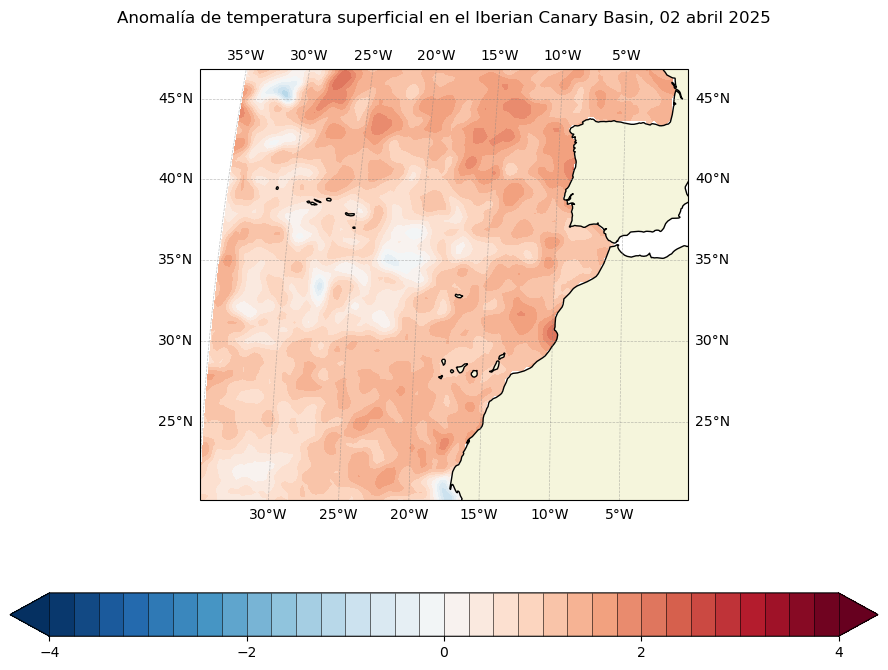

In [85]:
fig = plt.figure(figsize=(14,8))
ax = plt.axes(projection=ccrs.Robinson())

land = cartopy.feature.NaturalEarthFeature('physical', 
                'land', edgecolor='k', scale = escalaLand ,
                facecolor=cfeature.COLORS['land'])
ax.add_feature(land, facecolor='beige')
    
cm=ax.contourf(sst.lon,sst.lat,sst, levels=np.arange(-4,4.1,0.25), 
               transform=ccrs.PlateCarree(),
               cmap = plt.cm.RdBu.reversed(),
               vmin = -4,vmax = 4,extend='both')

cbar=fig.colorbar(cm,ax=ax, location='bottom',
                  shrink=.8, ticks=[-4,-2,0,2,4], 
                  drawedges=True)

ax.gridlines(draw_labels=True, linewidth=.5,color='gray', alpha=0.5, linestyle='--')
ax.set_title(Title + ', ' + sst.time.dt.strftime("%d %B %Y").values + '\n');

plt.savefig("Mapa_Prueba")
#plt.savefig(FileOut)